In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sksurv.ensemble import RandomSurvivalForest 
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.pipeline import  make_pipeline
from sksurv.metrics import concordance_index_censored,concordance_index_ipcw
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns


In [2]:
train = pd.read_csv('./data/post_early/HCC OP 20230511 train_early_input_derived features_std.csv')
test = pd.read_csv('./data/post_early/HCC OP 20230511 test_early_input_derived features_std.csv')
display(train.head())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,ln_AFP,ln_GGT,ln_CHOL,ln_ALK-P,ln_LDH,ln_GLU,ln_Histologic grade,Early recur,Early RFS,OP&RFA Data ID
0,-0.836070,0.821351,-0.545654,-0.241664,-0.140541,-0.121387,-0.786426,0.601544,-1.255512,-0.601866,...,-0.206479,-0.179515,-1.986548,-0.190394,-0.632077,1.540851,-1.477763,1,7.13,10741
1,-0.836070,1.164848,-0.545654,-0.241664,-0.140541,-0.121387,-0.673787,-0.314685,-0.595120,-1.217025,...,-0.730736,-1.052272,-0.030393,0.297650,0.709078,0.191393,-3.147601,1,13.13,10485
2,1.196072,0.799674,-0.545654,-0.241664,1.340874,-0.121387,-0.283884,-0.141345,-0.230865,0.107933,...,-0.410629,-1.117891,-0.770849,-0.553002,-0.085488,-0.497740,1.376844,0,24.00,10395
3,1.196072,-2.385170,1.832662,-0.241664,1.340874,-0.121387,-1.323625,-0.327067,-1.386967,-0.317946,...,-0.391522,-0.539075,0.962053,0.146753,0.634801,-0.730525,0.625984,1,12.27,10737
4,1.196072,-0.426741,-0.545654,-0.241664,-0.140541,-0.121387,0.175335,0.292007,0.025962,0.060614,...,-0.393414,0.322904,0.108111,-0.987914,-0.455974,-0.423621,-1.477763,0,24.00,10373


In [3]:
print(len(train))

1033


In [4]:
# selected = ['Tumor size', 'lnAFP', 'lnAST', 'Tumor number', 'BCLC', 'Ishak', 'lnGGT',
#  'Image_Vasulcar_invasion(Portal vein,Hepatic vein)', 'lnLDH',
#  'class_Histologic grade' ,'BUN' ,'APRI', 'CR', 'AFP' ,'BILI', 'Na', 'Weight',
#  'class_ALT' ,'GLU', 'class_Steatosis grade', 'lnALT' ,'class_PLAT', 'K',
#  'Steatosis grade', 'lnBUN' ,'ALBIgrade', 'HBsAg' ,'class_NLR']
# selected = ['Tumor size', 'ln_AST' ,'BCLC', 'Tumor number', 'ALBIgrade',
#  'class_Histologic grade', 'class_AFP', 'Ishak', 'Steatosis grade', 'K',
#  'class_Steatosis grade' ,'AST', 'HBsAg','Height','MVI',]
# selected = ['Tumor size', 'lnAST' ,'BCLC', 'Tumor number', 'ALBIgrade',
#  'class_Histologic grade', 'class_AFP', 'Ishak', 'Steatosis grade', 'K',
#  'class_Steatosis grade' ,'AST', 'HBsAg','BMI','MVI']
# selected = ['BCLC','ALB','BUN','APRI','GGT','Tumor size','Tumor number','Steatosis grade']
selected = ['Tumor size', 'ln_AST' , 'BCLC','Tumor number', 'ALBIgrade',
 'class_Histologic grade', 'class_AFP', 'Ishak','Steatosis grade', 'K' ,'class_Steatosis grade','MVI','BMI'
 ,'AST','HBsAg',]
selected = ['Tumor size', 'ln_AST' , 'BCLC','Tumor number', 'ALBIgrade', 'class_AFP', 'K' ,'BMI'
 ,'AST','HBsAg',]#臨床術前

In [5]:
X = train[ selected ]
y_struct = train[['Early recur','Early RFS']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])


In [6]:
coxnet = CoxnetSurvivalAnalysis()
coxnet.fit(X, y_struct)
print("fitted.")

fitted.


In [7]:
preds_train = coxnet.predict(X)
concordance_index_censored(train['Early recur'] > 0, train['Early RFS'],preds_train)

#concordance_index_ipcw((censored_test, survival_test, preds ))

(0.7289264439777575, 220751, 82093, 0, 57)

In [8]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(train['Early recur'] > 0, preds_train)
print("AUC:", auc)

AUC: 0.7388808192610745


In [9]:
test_X_std = test[train.columns].drop(columns=['Early recur', 'Early RFS'])
test_X_std = test_X_std[selected]

In [10]:
y_struct_test = test[['Early recur', 'Early RFS']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [11]:
preds = coxnet.predict(test_X_std)
concordance_index_censored(test['Early recur'] > 0, test['Early RFS'],preds)
#concordance_index_ipcw(y_struct,y_struct_test , preds)

(0.7259852873236433, 40857, 15421, 0, 5)

In [12]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test['Early recur'] > 0, preds)
print("AUC:", auc)

AUC: 0.7441344950947041


算HR Pvalue

In [3]:
import pandas as pd
from lifelines import CoxPHFitter

selected1 = ['Tumor size', 'ln_AST' , 'BCLC','Tumor number', 'ALBIgrade',
 'class_Histologic grade', 'class_AFP', 'Ishak','Steatosis grade', 'K' ,'class_Steatosis grade','MVI','BMI'
 ,'AST','HBsAg','Early recur','Early RFS']
data = train[ selected1 ]

# 定義要進行單變量分析的變數名列表
variables = ['Tumor size', 'ln_AST' , 'BCLC','Tumor number', 'ALBIgrade',
 'class_Histologic grade', 'class_AFP', 'Ishak','Steatosis grade', 'K' ,'class_Steatosis grade','MVI','BMI'
 ,'AST','HBsAg',]

# 用來儲存結果的資料框
univariate_results = pd.DataFrame(columns=['Variable', 'p-value', 'Hazard Ratio'])

# 進行單變量 Cox 分析
for var in variables:
    cox_model = CoxPHFitter()
    
    # 只選擇生存時間、事件和當前變數進行擬合
    cox_model.fit(data[['Early RFS', 'Early recur', var]], duration_col='Early RFS', event_col='Early recur')
    
     # 獲取當前變數的 p-value 和 HR
    summary = cox_model.summary
    p_value = summary['p'][0]  # 取得 p-value
    hazard_ratio = summary['exp(coef)'][0]  # 取得 hazard ratio
    
    # 使用 concat 將結果新增到結果資料框中
    univariate_results = pd.concat([univariate_results, pd.DataFrame({
        'Variable': [var],
        'p-value': [p_value],
        'Hazard Ratio': [hazard_ratio]
    })], ignore_index=True)

# 顯示結果
print(univariate_results)



                  Variable       p-value  Hazard Ratio
0               Tumor size  2.753355e-38      1.655971
1                   ln_AST  3.826423e-16      1.446224
2                     BCLC  9.562718e-20      1.504967
3             Tumor number  9.114514e-11      1.222087
4                ALBIgrade  2.866868e-06      1.262293
5   class_Histologic grade  6.320404e-05      1.225428
6                class_AFP  1.929837e-12      1.442746
7                    Ishak  6.164803e-01      1.026321
8          Steatosis grade  4.422434e-01      0.961152
9                        K  8.532096e-01      1.009598
10   class_Steatosis grade  2.683501e-01      1.058927
11                     MVI  7.349916e-12      1.513713
12                     BMI  9.778879e-01      0.998574
13                     AST  2.711540e-10      1.259168
14                   HBsAg  5.541230e-02      1.105869


In [13]:
# 將模型保存到文件
# joblib.dump(coxnet, './result/OP_post_2year_coxnet_model_advance.joblib')
# joblib.dump(coxnet, './result/OP_pre_2year_coxnet_model.joblib')

['./result/OP_pre_2year_coxnet_model.joblib']

In [14]:
model = joblib.load('C:/Users/User/Desktop/garsl2.0/backend/data/EL-STACE-Predict-clinical-model-v231101a.bin')
# 提取特徵名稱
# 這裡假設模型有一個 feature_names_in_ 屬性
feature_names = model.feature_names_in_

# 打印特徵名稱
print("模型使用的特徵名稱:")
for name in feature_names:
    print(name)

模型使用的特徵名稱:
AFP-class
ALB-bc
Tumor size-ln
UpToScore-ln
UpToScore
FIB4-bc
Age-ln
UpToScore-bc
Tumor counts-ln
CR-bc
HCV
FIB4stage
AST-class
BUN-bc
FIB4
Tumor counts
ALT-bc
BILI
BCLC stage


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
model = joblib.load('./result/OP_post_2year_coxnet_model_advance.joblib')
# 提取特徵名稱
# 這裡假設模型有一個 feature_names_in_ 屬性
feature_names = model.feature_names_in_

# 打印特徵名稱
print("模型使用的特徵名稱:")
for name in feature_names:
    print(name)

模型使用的特徵名稱:
Tumor size
lnAST
BCLC
Tumor number
ALBIgrade
class_Histologic grade
class_AFP
Ishak
Steatosis grade
K
class_Steatosis grade
AST
HBsAg
Height
MVI


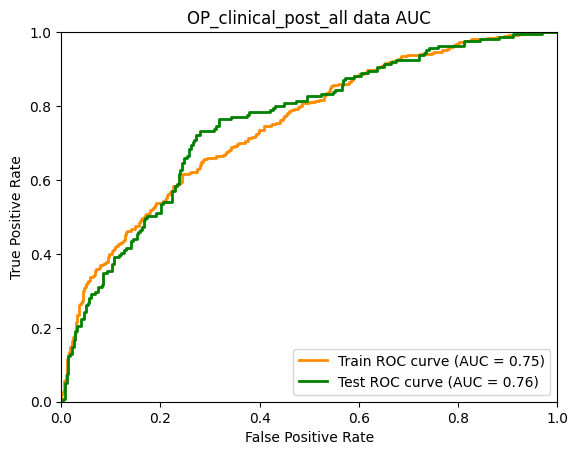

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# ...（您的其餘程式碼）

# 計算訓練集的AUC和繪製ROC曲線
fpr_train, tpr_train, thresholds_train = roc_curve(train['Early recur'] > 0, preds_train)
auc_train = roc_auc_score(train['Early recur'] > 0, preds_train)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (AUC = %0.2f)' % auc_train)

# 計算測試集的AUC和繪製ROC曲線
fpr_test, tpr_test, thresholds_test = roc_curve(test['Early recur'] > 0, preds)
auc_test = roc_auc_score(test['Early recur'] > 0, preds)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Test ROC curve (AUC = %0.2f)' % auc_test)

# 繪製ROC曲線
# plt.figure(figsize=(8, 6))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OP_clinical_post_all data AUC')
plt.legend(loc="lower right")
# plt.grid()
plt.savefig('./result/統計圖表/OP_post_2year/OP_clinical_post_all data AUC.png')
plt.show()


In [91]:
test_low = test[ preds < 0 ]
# test_med = test[ (preds > -0.29) & (preds <0.55) ]
test_high = test[ preds >= 0 ]

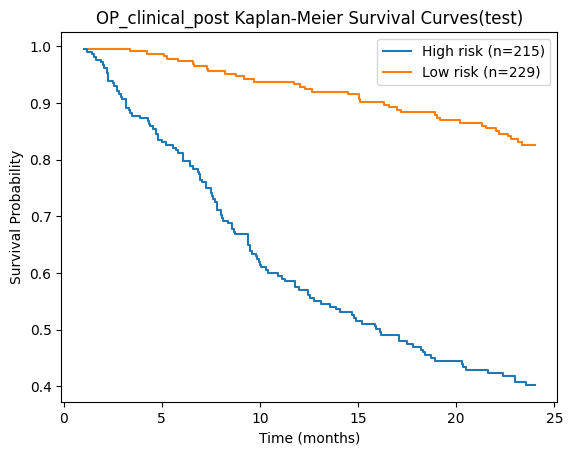

In [94]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Early recur'].astype("bool"),test_high['Early RFS'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')


time_low, survival_prob_low = kaplan_meier_estimator(test_low['Early recur'].astype("bool"),test_low['Early RFS'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('OP_clinical_post Kaplan-Meier Survival Curves(test)')
plt.legend()
plt.savefig('./result/統計圖表/OP_post_2year/Test km_plot high low(OP_post_2year).png')
plt.show()


CoxPH

In [5]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X, y_struct)
print("fitted.")

fitted.


In [6]:
test_X_std = test[train.columns].drop(columns=['Early recur', 'Early RFS'])
test_X_std = test_X_std[selected]

In [7]:
preds_train = cph.predict(X)
concordance_index_censored(train['Early recur'] > 0, train['Early RFS'],preds_train)

(0.7352597376867298, 222669, 80175, 0, 57)

In [8]:
preds = cph.predict(test_X_std)
concordance_index_censored(test['Early recur'] > 0, test['Early RFS'],preds)

(0.7305341341199048, 41113, 15165, 0, 5)

In [41]:
from sklearn.metrics import roc_auc_score

# 假設您已經建立好並適配了 Cox 模型，並命名為 `cox_model`
# 請確保您的模型已經適配了訓練數據

# 使用 Cox 模型預測風險分數
predicted_scores = cph.predict(test_X_std)

# 計算 AUC
auc = roc_auc_score(test['Early recur'], predicted_scores)

print("AUC:", auc)

AUC: 0.7137370234620196


In [16]:
# 將模型保存到文件
joblib.dump(cph, './result/OP_post_overall_coxph_model.joblib')

['./result/OP_post_overall_coxph_model.joblib']

In [17]:
train['riskscore'] = coxnet.predict(X)

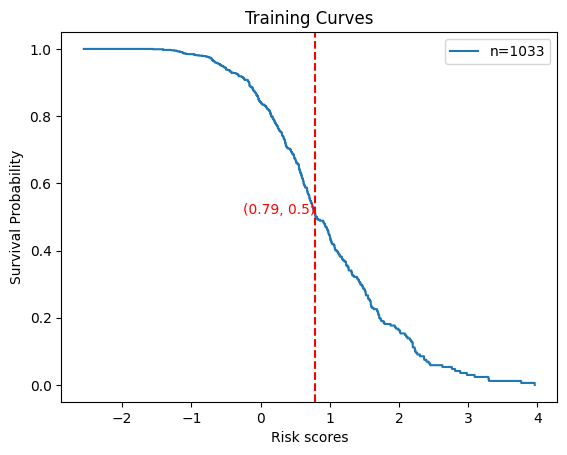

In [18]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
# time_high, survival_prob_high = kaplan_meier_estimator(test['riskscore'].astype("bool"),test['Recurrence free survival'])
time_high, survival_prob_high = kaplan_meier_estimator(train['Early recur'].astype("bool"),train['riskscore'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count = len(train)
plt.step(time_high, survival_prob_high, where="post",label=f'n={count}')
plt.xlabel('Risk scores')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Training Curves')
plt.legend()
# 找到 ylabel 為 0.5 的對應 xlabel 數值
ylabel_0_5 = 0.5
index = np.abs(survival_prob_high - ylabel_0_5).argmin()
xlabel_at_0_5 = time_high[index]
plt.axvline(x=xlabel_at_0_5, color='red', linestyle='--')
plt.text(xlabel_at_0_5, ylabel_0_5, f'{xlabel_at_0_5.round(2),ylabel_0_5}', color='red', ha='right', va='bottom')


plt.savefig('./result/統計圖表/OP_post_2year/Training Curves(OP_post_2year).png')
plt.show()

In [14]:
for i in range(len(test_X_std)):
    print("ID: {}, Risk Score: {}".format(test_X_std.index[i], preds[i]))

ID: 0, Risk Score: 0.15433679467914807
ID: 1, Risk Score: 1.2721895544311577
ID: 2, Risk Score: 0.5829809858311206
ID: 3, Risk Score: 0.8568001283407217
ID: 4, Risk Score: -0.2748698538050796
ID: 5, Risk Score: -0.31717280084470745
ID: 6, Risk Score: 0.6850944306854112
ID: 7, Risk Score: 0.24345287665294907
ID: 8, Risk Score: 0.2633162219068401
ID: 9, Risk Score: -0.23483023409261172
ID: 10, Risk Score: 0.2589353154906855
ID: 11, Risk Score: 0.42537400581588436
ID: 12, Risk Score: -0.10045920065274455
ID: 13, Risk Score: -0.22617813568984363
ID: 14, Risk Score: -0.1916055452949582
ID: 15, Risk Score: 0.16266127635043487
ID: 16, Risk Score: 0.9439458494173605
ID: 17, Risk Score: 0.7237598429932703
ID: 18, Risk Score: -0.05133363596236752
ID: 19, Risk Score: -0.5847901377660265
ID: 20, Risk Score: 0.19876655300486945
ID: 21, Risk Score: 0.12732731097064004
ID: 22, Risk Score: 0.002517332013693821
ID: 23, Risk Score: -0.036925538337527625
ID: 24, Risk Score: -0.4735857700305541
ID: 25, Ri

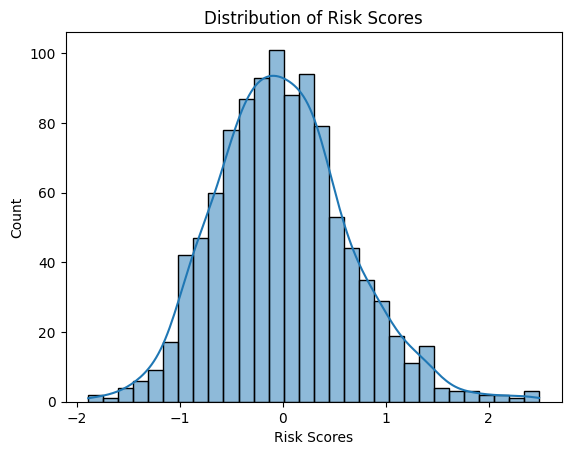

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of Risk Scores')
plt.show()

以人數30%切點切出risk score當作threshold

Threshold at 30%: -0.4244191102017738


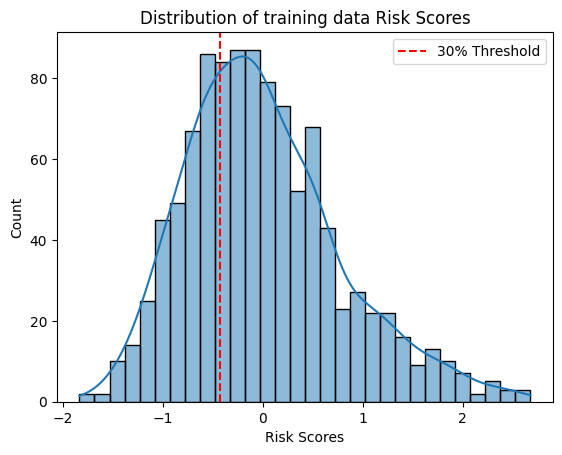

In [41]:
# 將 preds_train 由低至高排序
sorted_preds = sorted(preds_train)

# 計算第 70% 的索引位置
index_70_percent = int(0.32 * len(sorted_preds))

# 印出第 70% 的數值
threshold_70_percent = sorted_preds[index_70_percent]
print("Threshold at 30%:", threshold_70_percent)

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')
plt.axvline(x=threshold_70_percent, color='red', linestyle='--', label='30% Threshold')
plt.legend()
# plt.savefig('./data_cluster/統計圖表/train1.png')
plt.show()

以train的95%信賴區間切三等份當作threshold

Cut Point 1: -1.2485442530631845
Cut Point 2: 1.8505131351420279


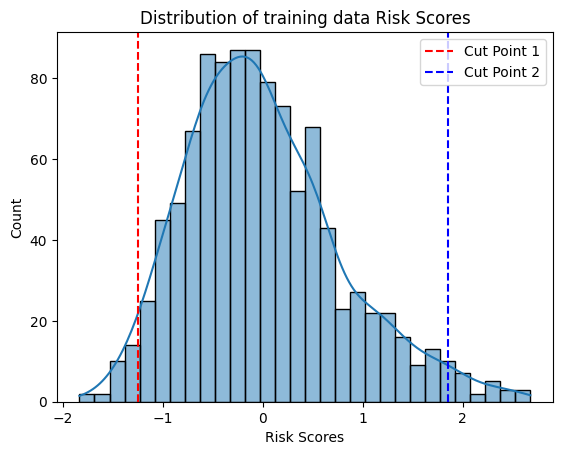

In [42]:
import numpy as np

# 計算 95% 信賴區間
lower_bound = np.percentile(preds_train, 2.5)
upper_bound = np.percentile(preds_train, 97.5)

# 將信賴區間分成三等分的切點
cut_points = [lower_bound, upper_bound]

# 分割資料成三個區間
low_data = preds_train[preds_train <= cut_points[0]]
medium_data = preds_train[(preds_train > cut_points[0]) & (preds_train < cut_points[1])]
high_data = preds_train[preds_train >= cut_points[1]]

# 列印切點數值
print("Cut Point 1:", cut_points[0])
print("Cut Point 2:", cut_points[1])

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')

# 繪製切點垂直線
plt.axvline(x=cut_points[0], color='red', linestyle='--', label='Cut Point 1')
plt.axvline(x=cut_points[1], color='blue', linestyle='--', label='Cut Point 2')
plt.legend()
plt.show()


Cut Point 1: -0.2924424373429265
Cut Point 2: 0.5446781970613734


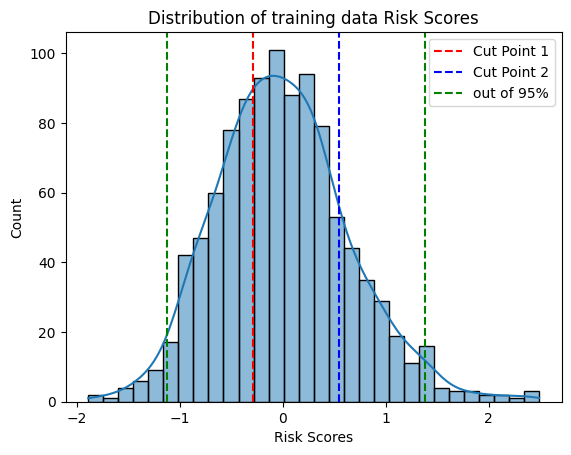

In [11]:
import numpy as np

# 計算 95% 信賴區間
lower_bound = np.percentile(preds_train, 2.5)
upper_bound = np.percentile(preds_train, 97.5)
cut_points = [lower_bound, upper_bound]
# 將信賴區間切成三等份的切點
cut_point1 = lower_bound + (upper_bound - lower_bound) / 3
cut_point2 = lower_bound + (upper_bound - lower_bound) * 2 / 3

# 列印切點數值
print("Cut Point 1:", cut_point1)
print("Cut Point 2:", cut_point2)

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')

# 繪製切點垂直線
plt.axvline(x=cut_point1, color='red', linestyle='--', label='Cut Point 1')
plt.axvline(x=cut_point2, color='blue', linestyle='--', label='Cut Point 2')
plt.axvline(x=cut_points[0], color='green', linestyle='--', label='out of 95%')
plt.axvline(x=cut_points[1], color='green', linestyle='--')
plt.legend()
#plt.savefig('./data_cluster/統計圖表/train 95% .png')
plt.show()


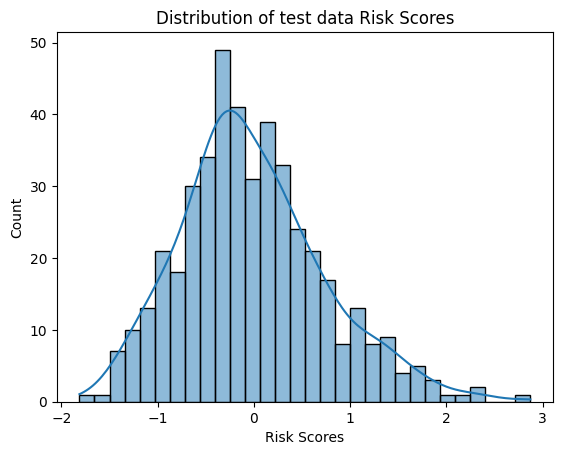

In [44]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(preds, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of test data Risk Scores')
#plt.savefig('./data_cluster/統計圖表/test1.png')
plt.show()


In [12]:
train_low = train[ preds_train <=-0.29 ]
train_med = train[ (preds_train > -0.29) & (preds_train <0.55) ]
train_high = train[ preds_train >= 0.55 ]

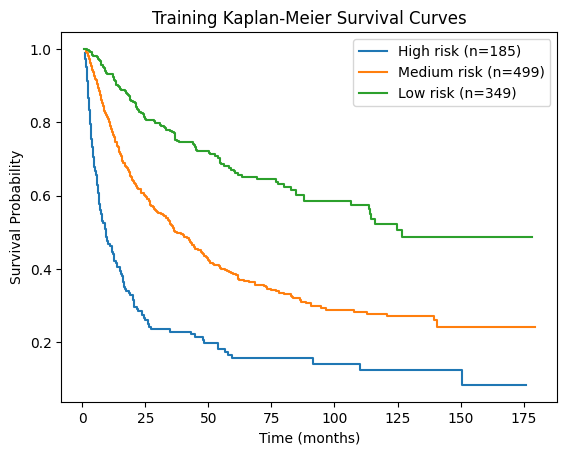

In [13]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(train_high['Recur'].astype("bool"),train_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(train_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_med, survival_prob_med = kaplan_meier_estimator(train_med['Recur'].astype("bool"),train_med['Recurrence free survival'])
#plt.plot(time_med, survival_prob_med, drawstyle='steps-post', label="steps-post")
count_med = len(train_med)
plt.step(time_med, survival_prob_med, where="post",label=f'Medium risk (n={count_med})')

time_low, survival_prob_low = kaplan_meier_estimator(train_low['Recur'].astype("bool"),train_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(train_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Training Kaplan-Meier Survival Curves')
plt.legend()
#plt.savefig('./result/統計圖表/Training kmplot high low med(OP_post).png')
plt.show()


In [14]:
test_low = test[ preds <=-0.29 ]
test_med = test[ (preds > -0.29) & (preds <0.55) ]
test_high = test[ preds >= 0.55 ]

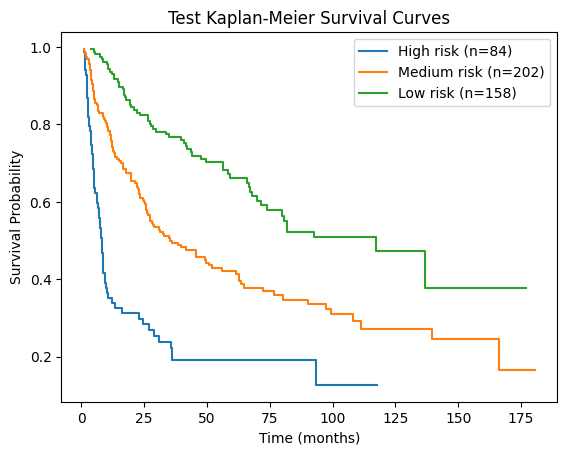

In [16]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Recur'].astype("bool"),test_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_med, survival_prob_med = kaplan_meier_estimator(test_med['Recur'].astype("bool"),test_med['Recurrence free survival'])
#plt.plot(time_med, survival_prob_med, drawstyle='steps-post', label="steps-post")
count_med = len(test_med)
plt.step(time_med, survival_prob_med, where="post",label=f'Medium risk (n={count_med})')

time_low, survival_prob_low = kaplan_meier_estimator(test_low['Recur'].astype("bool"),test_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Test Kaplan-Meier Survival Curves')
plt.legend()
# plt.savefig('./result/統計圖表/test kmplot high low med(OP_post).png')
plt.show()


In [31]:
test_low = test[ preds <= 0.79]
test_high = test[ preds > 0.79 ]

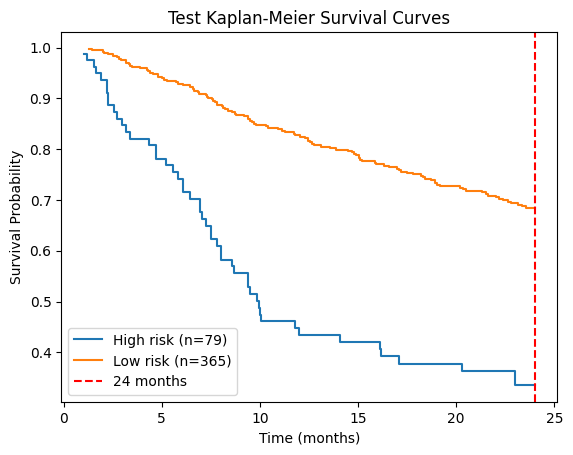

In [32]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Early recur'].astype("bool"),test_high['Early RFS'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_low, survival_prob_low = kaplan_meier_estimator(test_low['Early recur'].astype("bool"),test_low['Early RFS'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Test Kaplan-Meier Survival Curves')
plt.legend()
plt.savefig('./result/統計圖表/OP_post_2year/Test km_plot high low(OP_post_2year).png')
plt.show()


繪製個人累積風險函數

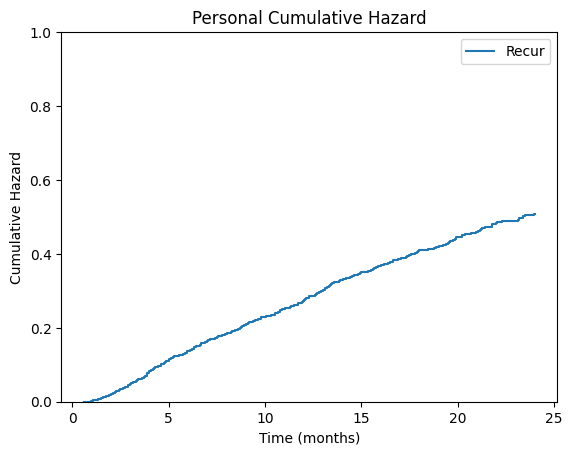

In [18]:
# preds = cph.predict(test_X_std)
# concordance_index_censored(test['Early recur'] > 0, test['Early RFS'],preds)
# estimator = CoxPHSurvivalAnalysis().fit(X, y_struct)
import matplotlib.pyplot as plt
chf_funcs = cph.predict_cumulative_hazard_function(X.iloc[:1])
for fn in chf_funcs:
    plt.step(fn.x, fn(fn.x), where="post",label="Recur")
plt.title('Personal Cumulative Hazard')
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Hazard')
plt.ylim(0, 1)
plt.legend()
plt.show()

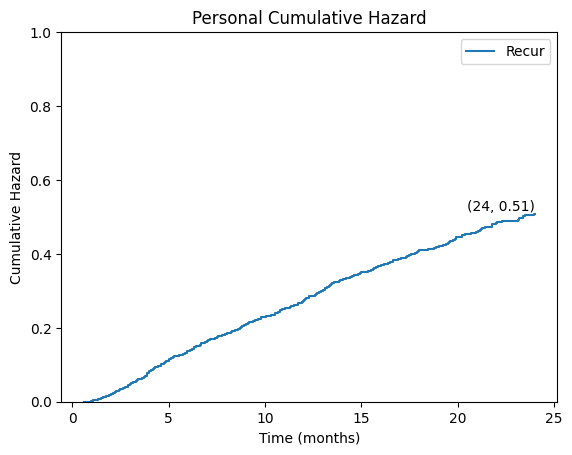

In [24]:
import matplotlib.pyplot as plt

chf_funcs = cph.predict_cumulative_hazard_function(X.iloc[:1])
for fn in chf_funcs:
    plt.step(fn.x, fn(fn.x), where="post", label="Recur")

# 指定要標示的 x 座標
x_coord = 24

# 尋找最接近指定 x 座標的 y 值
for fn in chf_funcs:
    y_coord = fn(x_coord)
    plt.text(x_coord, y_coord, f'({x_coord}, {y_coord:.2f})', ha='right', va='bottom')

plt.title('Personal Cumulative Hazard')
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Hazard')
plt.ylim(0, 1)
plt.legend()
plt.show()


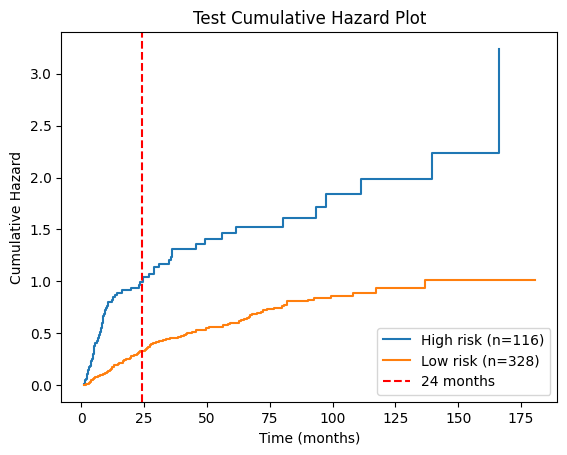

In [23]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = nelson_aalen_estimator(test_high['Recur'].astype("bool"),test_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_low, survival_prob_low = nelson_aalen_estimator(test_low['Recur'].astype("bool"),test_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Hazard')
# 設定圖表的標題
plt.title('Test Cumulative Hazard Plot')
plt.legend()
plt.savefig('./result/統計圖表/Test Cumulative Hazard Plot high low(OP_post).png')
plt.show()


建立非線性模型

In [23]:
train = pd.read_csv('./data/RFA_lnV2_noISD_train_0419_std.csv')
test = pd.read_csv('./data/RFA_lnV2_noISD_test_0419_std.csv')

In [24]:
selected = ['lnPLAT','CR' ,'APRI' ,'FIB4' ,'BUN', 'Tumor size' ,'PTINR' ,'lnALT','Child_Class','AFP' ,'Weight']#gen=100 conv_gen=30 survtree

In [25]:
X = train[ selected ]
y_struct = train[['Recur', 'Recurrence free survival']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [26]:
test_X_std = test[train.columns].drop(columns=['Recur', 'Recurrence free survival'])
test_X_std = test_X_std[selected]

SurvivalTree

In [27]:
from sksurv.tree import SurvivalTree

estimator = SurvivalTree().fit(X, y_struct)

preds = estimator.predict(test_X_std)

concordance_index_censored(test['Recur'] > 0, test['Recurrence free survival'],preds)


(0.5157909381811436, 10834, 10153, 576, 1)

In [29]:
preds = estimator.predict(X)
concordance_index_censored(train['Recur'] > 0, train['Recurrence free survival'],preds)

(0.8682501376010838, 102287, 15310, 498, 25)

RandomSurvivalForest

In [47]:
combined[ (combined['Recur']==1) & (combined['Recurrence free survival'] <=24) ].index

Int64Index([  0,   2,   4,   5,   8,   9,  10,  11,  13,  14,
            ...
            137, 138, 139, 140, 142, 143, 144, 146, 147, 149],
           dtype='int64', length=355)

<AxesSubplot: ylabel='Count'>

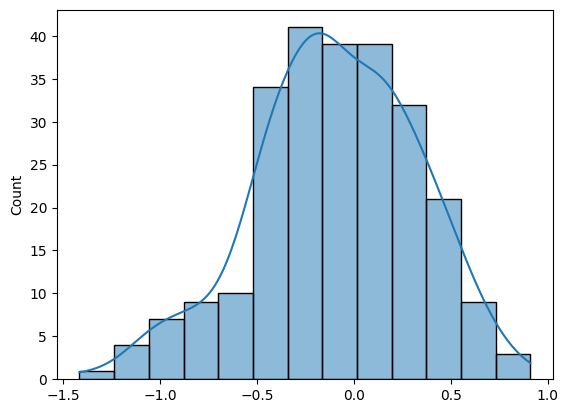

In [53]:
sns.histplot([ preds_all[idx] for idx in combined[ (combined['Recur']==0)  ].index ], kde=True)

<AxesSubplot: ylabel='Count'>

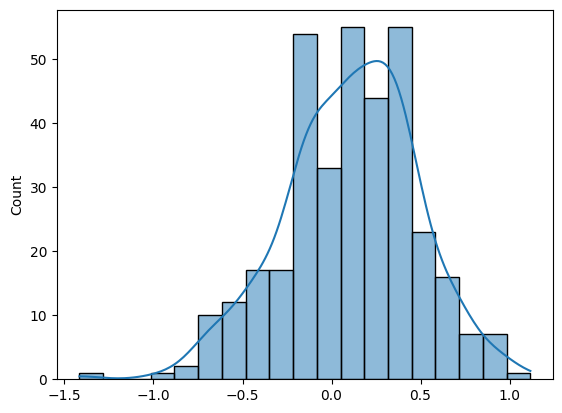

In [51]:
sns.histplot([ preds_all[idx] for idx in combined[ (combined['Recur']==1) & (combined['Recurrence free survival'] <=24) ].index ], kde=True)